In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import optuna
import wandb
import gc

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
os.makedirs("/workspace/Optuna-Trials/Plant-Pathology-Classificator-Conv2D-Trials", exist_ok = True)

In [4]:
gc.collect()
tf.keras.backend.clear_session()

In [5]:
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Carga de los datos 

df = pd.read_csv("/Plant-Pathology-Classificator/plant-pathology-2020-/train.csv")
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
import os

df["label"] = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)

df["filepath"] = df['image_id'].apply(lambda x: os.path.join("/Plant-Pathology-Classificator/plant-pathology-2020-/images", f'{x}.jpg'))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(df, test_size = 0.5, stratify = df["label"], random_state = 4)

X_test, X_val = train_test_split(X_temp, test_size = 0.4, stratify = X_temp["label"], random_state = 4)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 910
Validation size: 365
Test size: 546


In [9]:
mini_train, _ = train_test_split(X_train, test_size = 0.6, stratify = X_train["label"], random_state = 4)

mini_val, _ = train_test_split(X_val, test_size = 0.2, stratify = X_val["label"], random_state = 4)

print("Small training size:", len(mini_train))
print("Small val size:", len(mini_val))

Small training size: 364
Small val size: 292


In [10]:
def color_saturation_filter(img):
    
    # Convertir a uint8
    if img.dtype == np.float32 and img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Convertir RGB a HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)

    # Rangos de matiz
    red_mask1 = (h < 10)
    red_mask2 = (h > 170)
    orange_yellow_mask = (h >= 10) & (h <= 30)
    green_mask = (h >= 35) & (h <= 85)
    cyan_blue_mask = (h >= 90) & (h <= 130)

    # Saturar rojo, naranja y amarillo
    s[red_mask1 | red_mask2 | orange_yellow_mask] *= 3.0

    # Disminuir tonos azules
    s[cyan_blue_mask] *= 0.7
    
    # Disminuir saturación del verde
    s[green_mask] *= 0.7   

    # Disminuir luminancia del verde
    v[green_mask] *= 0.85 

    # Recortar valores a [0,255]
    s = np.clip(s, 0, 255)
    v = np.clip(v, 0, 255)

    # Juntar y convertir en RGB
    hsv_mod = cv2.merge([h, s, v]).astype(np.uint8)
    rgb_mod = cv2.cvtColor(hsv_mod, cv2.COLOR_HSV2RGB)

    return rgb_mod.astype(np.float32)


In [11]:
def custom_preprocessing(img):

    img = color_saturation_filter(img)
    
    return img

In [12]:
datagen_train = ImageDataGenerator(
    preprocessing_function = custom_preprocessing,
    rescale = 1./255,
    rotation_range = 0.01 ,          
    width_shift_range = 0.02,      
    height_shift_range = 0.02,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (1.0, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "nearest")

datagen_test_and_val = ImageDataGenerator(rescale = 1./255,
                                          preprocessing_function = custom_preprocessing,
                                          dtype = "float32")

In [13]:
train = datagen_train.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    seed = 4,
)

test = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False,
    seed = 4
)

val = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    shuffle = False,  
    seed = 4
)

Found 910 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.


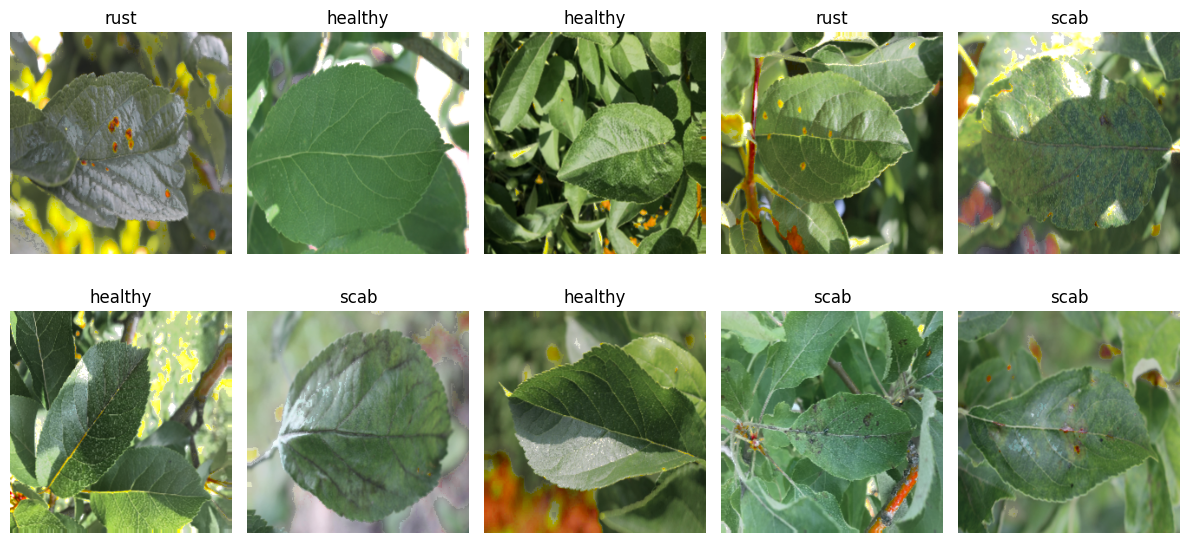

In [14]:
img, labels = next(train)

label_indices = np.argmax(labels, axis=1)
class_names = list(train.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

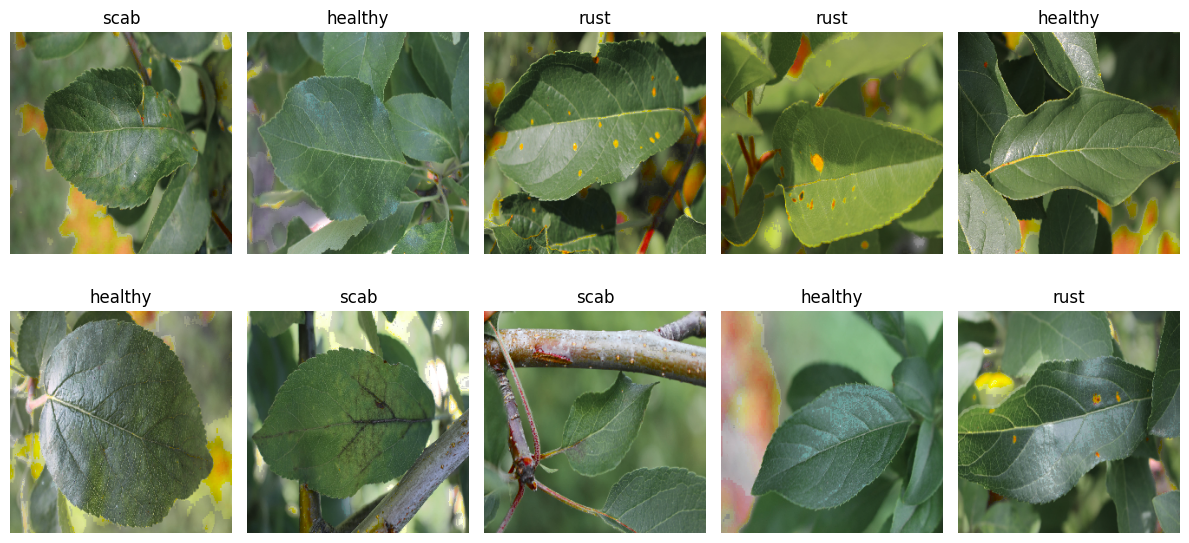

In [15]:
img, labels = next(val)

label_indices = np.argmax(labels, axis=1)
class_names = list(val.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [17]:
# def w_categorical_crossentropy(weights):
    
#     weights = tf.constant(weights, dtype=tf.float32)

#     def loss(y_true, y_pred):
#         y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
#         # Mutiplicación de cada clase por su peso
#         weighted_losses = y_true * tf.math.log(y_pred) * weights
#         # Suma sobre clases
#         return -tf.reduce_mean(tf.reduce_sum(weighted_losses, axis=-1))
    
#     return loss

In [18]:
# from sklearn.utils.class_weight import compute_class_weight

# labels = train.classes
# class_indices = train.class_indices 

# # Cálculo del peso por clase
# class_weights = compute_class_weight(
#     class_weight = "balanced",
#     classes = np.unique(labels),
#     y = labels
# )

# class_weights = dict(enumerate(class_weights))

# weights = np.zeros(4)

# for i in range (len(class_weights)):
#     weights[i] = class_weights[i]
    
# print(weights)

[I 2025-11-10 20:16:04,765] Trial 247 finished with value: 0.33933117985725403 and parameters: {'Kernel': 11, 'regularizador_0': 2.305266072890802e-05, 'Dropout0': 0.13788732206198168, 'regularizador_1': 6.742185481545807e-05, 'Dropout1': 0.14669695866381643, 'regularizador_2': 6.029301543352178e-05, 'Dropout2': 0.13759350655008273, 'Optimizador': 'RMSprop', 'Learning_rate': 0.0008008511418436235}. Best is trial 247 with value: 0.33933117985725403.

In [19]:
tf.keras.backend.clear_session()
    
model = models.Sequential()
inputs = layers.Input(shape=(128, 128, 3))

x = layers.Conv2D(16, (2,2), padding = "same")(inputs)
x = layers.Activation("relu")(x)
    
kernels = [22,44,88]        
    
regularizers = [2.305266072890802e-05, 6.742185481545807e-05, 6.029301543352178e-05]
dropout = [2.305266072890802e-05, 6.742185481545807e-05, 6.029301543352178e-05]
    
for k in range(3):
    
    filters = kernels[k]
    r_2 = regularizers[k]
    drop = dropout[k]

    x = layers.Conv2D(filters, (3,3), activation = "relu", padding = "same",
                         kernel_regularizer = tf.keras.regularizers.l2(r_2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, (3,3), activation = "relu", padding = "same",
                         kernel_regularizer = tf.keras.regularizers.l2(r_2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(drop)(x)
    
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(4, activation = "softmax", dtype = "float32")(x)

model = models.Model(inputs, outputs)
    
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5)
    
lr = 0.0008008511418436235
    
optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr)
    
model.compile(optimizer = optimizer,
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    
wandb.init(
    project = "Plant-Pathology-Classificator-Conv2D-Filter-Series-1",
    name = "Trial_1",
    reinit = True,
    config = {
            "kernel_1": 16,
            "size_1": 2,
            "activation": "Relu",
            "n_layers": 3,
            "kernel_2": kernels[0],
            "kernel_2_size": (3,3),
            "kernel_3": kernels[1],
            "kernel_3_size": (3,3),
            "kernel_4": kernels[2],
            "kernel_4_size": (3,3),
            "regularizer": "L2",
            "r_21": regularizers[0],
            "r_22": regularizers[1],
            "r_23": regularizers[2],
            "Dropout_1": dropout[0],
            "Dropout_2": dropout[1],
            "Dropout_3": dropout[2],
            "learning_rate": lr,
            "optimizer": "RMSprop",
            "loss" : "Categorical CrossEntropy"
        }
    ) 
model.summary()     

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 22)      3190      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 22)     88        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 22)      4378      
                                                             

In [20]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 7)

history = model.fit(
            train,
            validation_data = val,
            epochs = 70,
            verbose = 1, 
            callbacks = [WandbMetricsLogger(log_freq = 5)]
        )
    
        
tf.keras.backend.clear_session()
gc.collect()
wandb.finish()

Epoch 1/70
29/29 [==============================] - 33s 820ms/step - loss: 1.3802 - accuracy: 0.4066 - val_loss: 1.4250 - val_accuracy: 0.0493
Epoch 2/70
29/29 [==============================] - 21s 725ms/step - loss: 1.2115 - accuracy: 0.4330 - val_loss: 1.4161 - val_accuracy: 0.1370
Epoch 3/70
29/29 [==============================] - 21s 713ms/step - loss: 1.1660 - accuracy: 0.4736 - val_loss: 1.3678 - val_accuracy: 0.2822
Epoch 4/70
29/29 [==============================] - 21s 702ms/step - loss: 1.1401 - accuracy: 0.4967 - val_loss: 1.4069 - val_accuracy: 0.3425
Epoch 5/70
29/29 [==============================] - 21s 729ms/step - loss: 1.0929 - accuracy: 0.5308 - val_loss: 1.5937 - val_accuracy: 0.2822
Epoch 6/70
29/29 [==============================] - 21s 719ms/step - loss: 1.0225 - accuracy: 0.5780 - val_loss: 1.8783 - val_accuracy: 0.2822
Epoch 7/70
29/29 [==============================] - 21s 719ms/step - loss: 0.9795 - accuracy: 0.6132 - val_loss: 1.8343 - val_accuracy: 0.2247

Epoch 58/70
29/29 [==============================] - 21s 731ms/step - loss: 0.1800 - accuracy: 0.9527 - val_loss: 0.4957 - val_accuracy: 0.8630
Epoch 59/70
29/29 [==============================] - 21s 728ms/step - loss: 0.2003 - accuracy: 0.9341 - val_loss: 0.4054 - val_accuracy: 0.8712
Epoch 60/70
29/29 [==============================] - 22s 738ms/step - loss: 0.1695 - accuracy: 0.9505 - val_loss: 0.3942 - val_accuracy: 0.8685
Epoch 61/70
29/29 [==============================] - 21s 708ms/step - loss: 0.1731 - accuracy: 0.9571 - val_loss: 0.5121 - val_accuracy: 0.8877
Epoch 62/70
29/29 [==============================] - 22s 746ms/step - loss: 0.1751 - accuracy: 0.9451 - val_loss: 0.3988 - val_accuracy: 0.8986
Epoch 63/70
29/29 [==============================] - 21s 729ms/step - loss: 0.1928 - accuracy: 0.9451 - val_loss: 0.3595 - val_accuracy: 0.9068
Epoch 64/70
29/29 [==============================] - 22s 735ms/step - loss: 0.1997 - accuracy: 0.9473 - val_loss: 0.3465 - val_accuracy:

batch/accuracy,▁▁▂▂▂▄▄▅▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇▇█
batch/batch_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▆▆▅▅▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▂▂▂▂▂▃▄▅▄▆▅▆▆▇▇▇▇▇▆██████▇▇██████████
epoch/val_loss,▄▄▄▄▅█▆▅▄▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▂▁
batch/accuracy,0.96437


In [21]:
model.save("Plant-Pathology-Classificator-Conv2D-Filter-Model.h5")

In [22]:
model.save_weights("Plant-Pathology-Classificator-Conv2D-Filter-Model.weights.h5")

In [23]:
model.save("Plant-Pathology-Classificator-Conv2D-Filter-Model.keras")

In [26]:
model_ev = keras.models.load_model("Plant-Pathology-Classificator-Conv2D-Filter-Model.h5")

# Evaluación del modelo

loss, accuracy = model_ev.evaluate(test, verbose = 1)

print(f"Test Loss: {loss:}")
print(f"Test Accuracy: {accuracy:}")

18/18 [==============================] - 5s 286ms/step - loss: 0.4323 - accuracy: 0.8828
Test Loss: 0.43234971165657043
Test Accuracy: 0.8827838897705078


In [ ]:
plt.plot(history.history["accuracy"], label = "Precisión durante el entrenamiento")
plt.plot(history.history["val_accuracy"], label="Precisión durante validación (Test)")
plt.title("Precisión del modelo")

plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["loss"], label = "Pérdida durante el entrenamiento")
plt.plot(history.history["val_loss"], label = "Pérdida durante la validación (Test)")
plt.title("Función de costo del modelo")

plt.grid()
plt.legend()
plt.show()